In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common_import import raw_dir, data_dir,tab_dir,fig_dir
from plot_helper import initialize_plot, draw_cdf

# Plot Configuration
initialize_plot()
black_white = True

legend_info = {'loc':"center",'borderaxespad':0.1,'bbox_to_anchor':(0.5,0.1),'ncol':3}

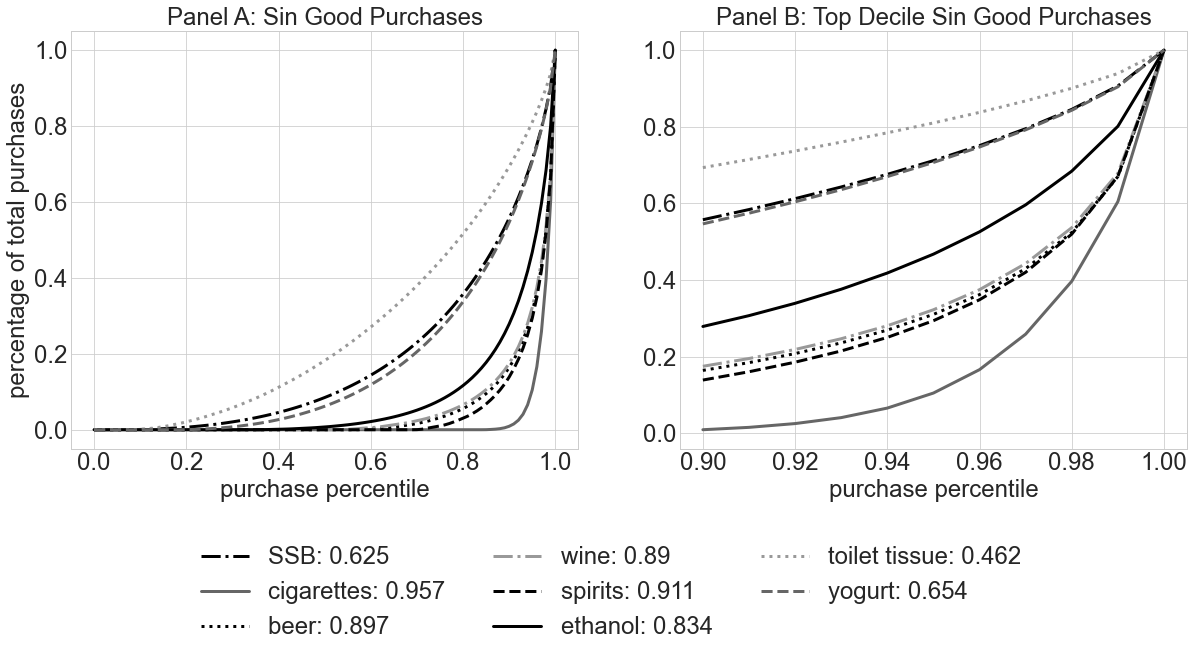

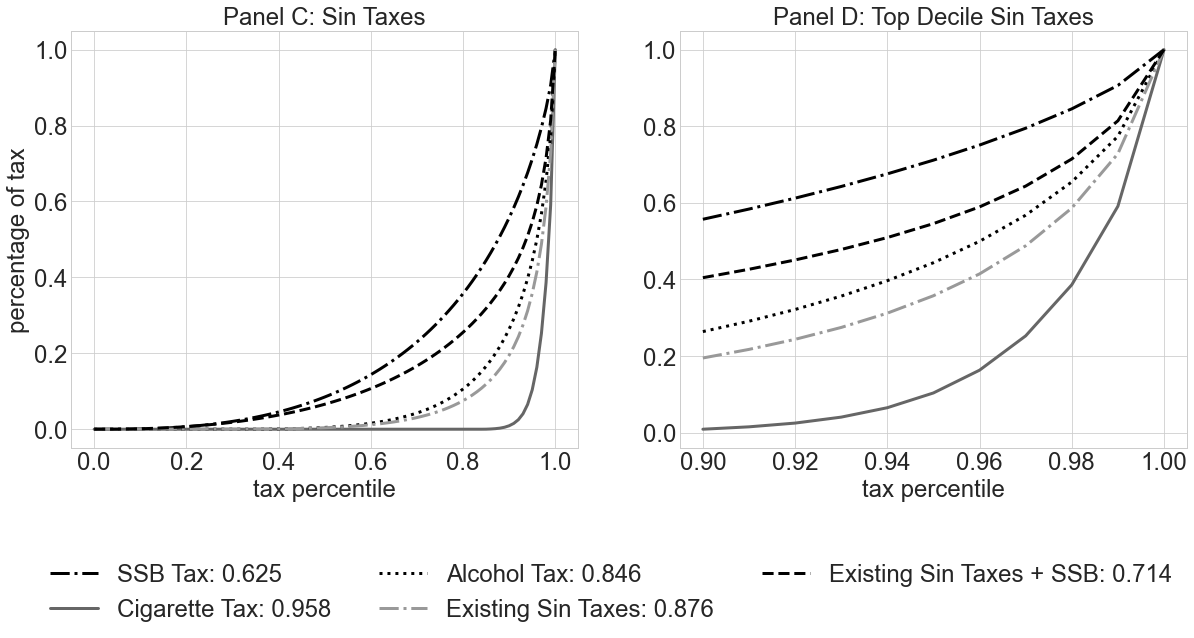

In [22]:
df = pd.read_parquet(data_dir/'panel_data_all_years.parquet')
df['alcohol_tax'] = df['beer_tax'] + df['spirits_tax'] +df['wine_tax']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
legend_labels=draw_cdf(df, ax1, ax2, taxes=False, use_bw=black_white)
fig.legend(labels=legend_labels,**legend_info)

# Create the legend
plt.subplots_adjust(bottom=0.3)
plt.savefig(fig_dir/'Figure1A.pdf',bbox_inches="tight")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
legend_labels=draw_cdf(df, ax1, ax2, taxes=True, use_bw=black_white)

fig.legend(
    labels=legend_labels,   # The labels for each line
    loc="center",   # Position of legend
    borderaxespad=0.1,    # Small spacing around legend box
    #title="Consumption Type",  # Title for the legend
    bbox_to_anchor=(0.5,0.1),
    ncol=3
)

# Create the legend
plt.subplots_adjust(bottom=0.3)
plt.savefig(fig_dir/'Figure1B.pdf',bbox_inches="tight")

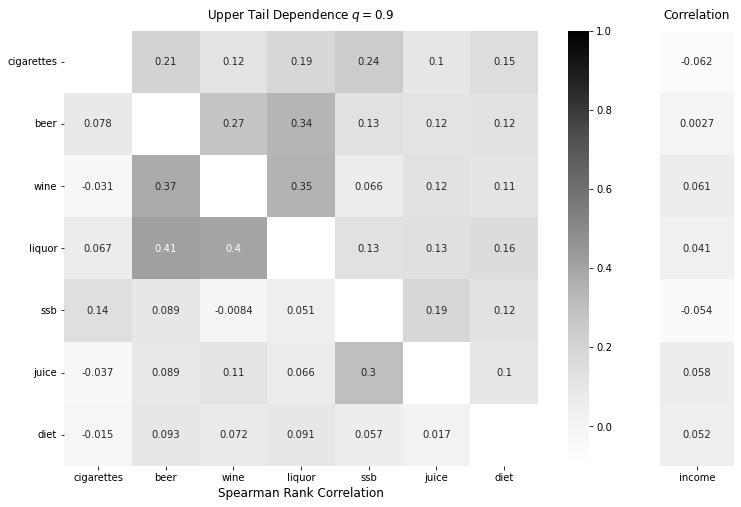

In [13]:
import seaborn as sns
from scipy.stats import kendalltau
from itertools import combinations 
import pycop
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pycop.bivariate import empirical
from common_import import data_dir,tab_dir,fig_dir
#Input
fn_panel = data_dir / 'panel_data_all_years.parquet'

rename_dict={'cigars':'cigarettes','carbonated':'ssb'}
df = pd.read_parquet(fn_panel).query('panel_year==2018').rename(columns=rename_dict)

cols=['cigarettes','beer','wine','liquor','ssb','juice','diet','yogurt','toilet_tissue']
cols=['cigarettes','beer','wine','liquor','ssb','juice','diet']

mask = np.triu(np.ones_like(df[cols].corr()))

def plot_income(df, income_df,title_top, title_bottom):
	fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(12,8), gridspec_kw={'width_ratios': [8, 1]})
	fig.subplots_adjust(wspace=0.01)
	sns.heatmap(df, mask=np.eye(mask.shape[0]), vmin=-.1, vmax=1, annot=True,cmap='Greys',cbar=True, ax = ax)
	ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
	ax.set_title(title_top, fontdict={'fontsize':12}, pad=12)
	ax.set_xlabel(title_bottom, fontdict={'fontsize':12})
	ax2=sns.heatmap(income_df, vmin=-.1, vmax=1, annot=True,cmap='Greys', cbar=False, ax = ax2, yticklabels=False)
	ax2.set_title('Correlation', fontdict={'fontsize':12}, pad=12)
    

pearson = df[cols].corr()
spearman =df[cols].rank(ascending=True,method='min').corr()

# tau
kendall=(df[cols].rank(ascending=True,method='min').corr().copy() >0)*0
for k in combinations(cols,2):
    kendall.loc[k[1],k[0]]=kendalltau(df[k[0]],df[k[1]])[0]

# tail dependence parameters
my_zeros = (spearman !=0)*0
y=my_zeros.copy()
z=my_zeros.copy()
for k in combinations(cols,2):
    y.loc[k[1],k[0]]=empirical(df[list(k)]).UTDC(0.9) 
    z.loc[k[1],k[0]]=empirical(df[list(k)]).UTDC(0.95)

out_df = kendall+y.transpose()
out_df['income'] = np.corrcoef(df[cols+['median_income']],rowvar=False)[0:-1,-1]


plot_income(spearman * (mask==0) + y.transpose(), out_df[['income']], r"Upper Tail Dependence $q=0.9$",r"Spearman Rank Correlation")
